Import libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import tensorflow.keras as keras

import random
import numpy as np
import sklearn.metrics 
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt


print("Libraries imported.")

Libraries imported.


Load Dataset from Drive



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing and using split-folders to create a training and a validation set

In [ ]:
%pip install split-folders tqdm

In [ ]:
import splitfolders

splitfolders.ratio('/content/drive/MyDrive/ML/Homework2/Data set', \
                   output='/content/drive/MyDrive/ML/Homework2/Splitted_Dataset',\
                   seed=1337, ratio=(.7, .3), group_prefix=None)

Output streaming troncato alle ultime 5000 righe.
Copying files: 3719 files [15:17,  5.03 files/s]
Copying files: 3720 files [15:18,  4.27 files/s]
Copying files: 3721 files [15:18,  4.52 files/s]
Copying files: 3722 files [15:18,  4.33 files/s]
Copying files: 3723 files [15:18,  4.60 files/s]
Copying files: 3724 files [15:19,  4.72 files/s]
Copying files: 3725 files [15:19,  4.68 files/s]
Copying files: 3726 files [15:19,  4.77 files/s]
Copying files: 3727 files [15:19,  4.97 files/s]
Copying files: 3728 files [15:19,  4.73 files/s]
Copying files: 3729 files [15:20,  4.90 files/s]
Copying files: 3730 files [15:20,  4.17 files/s]
Copying files: 3731 files [15:20,  4.40 files/s]
Copying files: 3732 files [15:20,  4.51 files/s]
Copying files: 3733 files [15:20,  4.65 files/s]
Copying files: 3734 files [15:21,  4.94 files/s]
Copying files: 3735 files [15:21,  5.19 files/s]
Copying files: 3736 files [15:21,  5.06 files/s]
Copying files: 3737 files [15:21,  5.10 files/s]
Copying files: 3738

Checking that the splitting has been correctly executed

In [3]:
import shutil

original_dataset_dir = '/content/drive/MyDrive/ML/Homework2/Splitted_Dataset'

train_dir = os.path.join(original_dataset_dir, 'train')
validation_dir = os.path.join(original_dataset_dir, 'val')
test_dir = os.path.join(original_dataset_dir, 'test')

if not os.path.exists(os.path.join(original_dataset_dir, 'test')):
  os.mkdir(test_dir)

folders = ['Caddies','Lollipops','Macaroni_&_Cheese_box','Melons',\
           'carving_knife_fork','juice_carton','plastic_food_container',\
           'water_glasses']


tot_train = 0
tot_val = 0
tot_test = len(os.listdir(test_dir))

for f in folders:
  tot_train = tot_train + len(os.listdir(train_dir + '/' + f))
  tot_val = tot_val + len(os.listdir(validation_dir + '/' + f))
  
print('total training images: '  + str(tot_train))
print('total validation images: ' + str(tot_val))
print('total test images: ' + str(tot_test))


total training images: 6067
total validation images: 2619
total test images: 32


In [ ]:
# Copying the first 50 images of each folder in the test_dir

for f in folders:
  src = os.path.join(train_dir, f)
  fnames = os.listdir(src)
  i = 0
  for fname in fnames:
    src = os.path.join(train_dir, f)
    dst = os.path.join(original_dataset_dir, 'test')
    if i != 4:
      src = os.path.join(src, fname)
      dst = os.path.join(dst, fname)
      shutil.move(src, dst)
      i += 1

Data Preprocessing

In [4]:
'''
1) Read the picture files.
2) Decode the JPEG content to RGB grids of pixels.
3) Convert these into floating-point tensors.
4) Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know,
   neural networks prefer to deal with small input values).
'''

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,\
                                                    target_size=(150, 150),\
                                                    batch_size=32,\
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_dir,\
                                                        target_size=(150, 150),\
                                                        batch_size=32,\
                                                        class_mode='categorical')

for data_batch, labels_batch in train_generator:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  break

Found 6067 images belonging to 8 classes.
Found 2619 images belonging to 8 classes.
data batch shape: (32, 150, 150, 3)
labels batch shape: (32, 8)


Instantiating the Convnet

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',\
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
# 8 and softmax, why?
model.add(layers.Dense(8, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 128)      

Configuring the model for training

In [ ]:
from keras import optimizers
#sparse categorical crossentropy and accuracy, why?
model.compile(optimizer='adam',\
              loss='categorical_crossentropy',\
              metrics=['accuracy'])

Fitting the model

In [ ]:
# steps_per_epoch = int(number_of_train_samples / batch_size)
# val_steps = (number_of_val_samples / batch_size)
history = model.fit(train_generator,steps_per_epoch=190,epochs=10,\
                              validation_data=validation_generator,validation_steps=82)


Epoch 1/10
190/190 [==============================] - 294s 2s/step - loss: 1.7468 - accuracy: 0.3102 - val_loss: 1.5697 - val_accuracy: 0.4177
Epoch 2/10
190/190 [==============================] - 291s 2s/step - loss: 1.4628 - accuracy: 0.4673 - val_loss: 1.3548 - val_accuracy: 0.5113
Epoch 3/10
190/190 [==============================] - 292s 2s/step - loss: 1.2584 - accuracy: 0.5611 - val_loss: 1.2649 - val_accuracy: 0.5521
Epoch 4/10
190/190 [==============================] - 292s 2s/step - loss: 1.1024 - accuracy: 0.6117 - val_loss: 1.2904 - val_accuracy: 0.5487
Epoch 5/10
190/190 [==============================] - 292s 2s/step - loss: 0.9577 - accuracy: 0.6644 - val_loss: 1.1284 - val_accuracy: 0.6113
Epoch 6/10
190/190 [==============================] - 296s 2s/step - loss: 0.7742 - accuracy: 0.7308 - val_loss: 1.2108 - val_accuracy: 0.6166
Epoch 7/10
190/190 [==============================] - 293s 2s/step - loss: 0.5855 - accuracy: 0.7979 - val_loss: 1.1832 - val_accuracy: 0.6426

Saving the model

In [ ]:
model.save('/content/drive/MyDrive/ML/Homework2/convnet1.h5')

Displaying curves of loss and accuracy

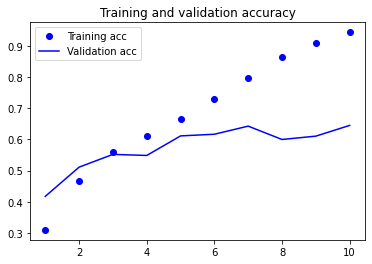

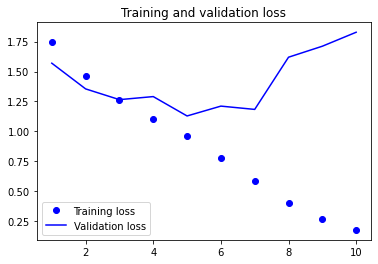

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


### Using data augmentation


Setting up a data augmentation configuration

In [5]:
datagen = ImageDataGenerator(rotation_range=40,width_shift_range=0.2,\
                             height_shift_range=0.2,shear_range=0.2,\
                             zoom_range=0.2,horizontal_flip=True,\
                             fill_mode='nearest')

Displaying some randomly augmented training images

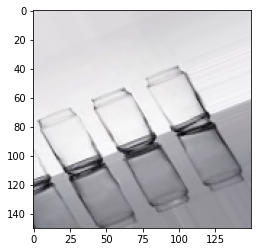

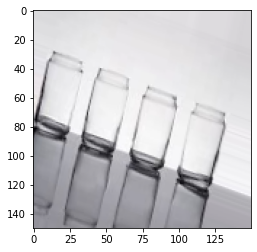

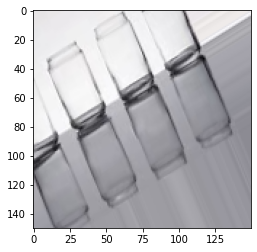

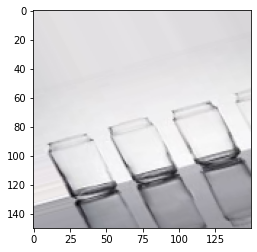

In [6]:
from keras.preprocessing import image

for f in folders:
  train_dirs = os.path.join(train_dir, f)
  fnames = [os.path.join(train_dirs, fname) for
            fname in os.listdir(train_dirs)]

img_path = fnames[3] 
img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img) 
x = x.reshape((1,) + x.shape)

i=0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 4 == 0:
    break
plt.show()

Defining a new convnet that includes dropout

In [7]:
from keras import layers
from keras import models

# To fight overfitting, we add a Dropout layer to the model
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu',\
                        input_shape=(150, 150, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(512, activation='relu'))
# 8 and softmax, why?
model2.add(layers.Dense(8, activation='softmax'))

model2.summary()

model2.compile(optimizer='adam',\
              loss='categorical_crossentropy',\
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

Training the convnet using data-augmentation generators

In [ ]:
#'old' with dropout
from keras import optimizers

train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=40,\
                                   width_shift_range=0.2,height_shift_range=0.2,\
                                   shear_range=0.2,zoom_range=0.2,\
                                   horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255)
# We aren't augmenting validation data

train_generator = train_datagen.flow_from_directory(train_dir,\
                                                    target_size=(150, 150),\
                                                    batch_size=32,\
                                                    class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(validation_dir,\
                                                         target_size=(150, 150),\
                                                         batch_size=32,\
                                                         class_mode='categorical')
 
history = model2.fit(train_generator,steps_per_epoch=190,epochs=30,validation_data=validation_generator,validation_steps=82)

Found 6067 images belonging to 8 classes.
Found 2619 images belonging to 8 classes.
Epoch 1/30
190/190 [==============================] - 3188s 17s/step - loss: 1.7796 - accuracy: 0.2936 - val_loss: 1.6269 - val_accuracy: 0.3562
Epoch 2/30
190/190 [==============================] - 288s 2s/step - loss: 1.6103 - accuracy: 0.3906 - val_loss: 1.5391 - val_accuracy: 0.4456
Epoch 3/30
190/190 [==============================] - 287s 2s/step - loss: 1.5068 - accuracy: 0.4452 - val_loss: 1.4495 - val_accuracy: 0.4681
Epoch 4/30
190/190 [==============================] - 286s 2s/step - loss: 1.4569 - accuracy: 0.4678 - val_loss: 1.3823 - val_accuracy: 0.5143
Epoch 5/30
190/190 [==============================] - 286s 2s/step - loss: 1.3896 - accuracy: 0.4915 - val_loss: 1.3159 - val_accuracy: 0.5284
Epoch 6/30
190/190 [==============================] - 286s 2s/step - loss: 1.3332 - accuracy: 0.5166 - val_loss: 1.2802 - val_accuracy: 0.5441
Epoch 7/30
190/190 [==============================] - 28

In [ ]:
model2.save('/content/drive/MyDrive/ML/Homework2/convnet2.h5')

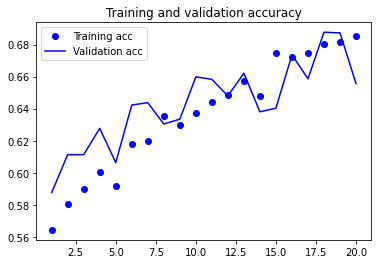

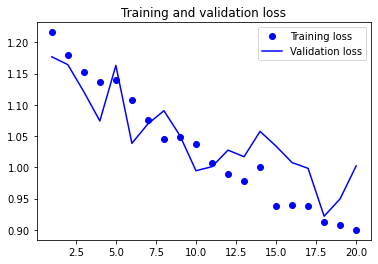

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()